In [ ]:
import scipy.sparse as sps
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.constants import k

def BdG_Hamiltonian(n,  delta_in, T,  t =1, V =1, periodic = True):
  '''
  Função que preenche uma SciPy Sparse Matrix baseada
  no número de sítios e nas regras de formação para as
  diagonais do sistema em questão

  Argumentos:
  n: número de sítios(int)
  delta_in: gap superconductor(float)
  T: Temperatura do sistema(float)
  t: Termo de hopping(float)
  V: Parâmetro superconductor
  periodic: Periodic Boundary Conditions(Boolean)

  Return: Retorna a matriz sparsa construída
  '''

  #Preenche somente uma vez os termos de hopping triangularmente
  aux = 1
  if(aux == 1):
    rows, cols = 2*n, 2*n
    hopping = sps.dok_matrix((rows, cols))
    values = t*np.ones((n-1))
    values = np.append(values, 0)
    values = np.append(values, -values)
    hopping.setdiag(values, k=1)
    if (periodic == True):
      hopping[0,n-1] = t
      hopping[n,2*n-1] = -t

    aux = 0


  #Preenche os deltas triangularmente
  delta = sps.dok_matrix((rows, cols))
  b = [delta_in for  i in range(n+1)]
  b[0], b[-1] = 0, 0
  delta.setdiag(b, k = n-1)
  b = b[1:-1]
  b = np.array(b)
  delta.setdiag(-b, n-1+2)
  if (periodic == True):
    delta[0, (n*2)-1] = -delta_in
    delta[n, n-1] = delta_in

  #Soma as duas matrizes
  f = delta + hopping

  #Prenche o triangulo inferior
  f = f.T + f

  return f

In [ ]:
import scipy.sparse as sps
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.constants import k

def BdG_Hamiltonian_Spin(n,  delta_in, T,  t =1, V =1, periodic = True):
  '''
  Função que preenche uma SciPy Sparse Matrix baseada
  no número de sítios e nas regras de formação para as
  diagonais do sistema em questão

  Argumentos:
  n: número de sítios(int)
  delta_in: gap superconductor(float)
  T: Temperatura do sistema(float)
  t: Termo de hopping(float)
  V: Parâmetro superconductor
  periodic: Periodic Boundary Conditions(Boolean)

  Return: Retorna a matriz sparsa construída
  '''

  #Preenche somente uma vez os termos de hopping triangularmente
  aux = 1
  if(aux == 1):
    rows, cols = 2*n, 2*n
    hopping = sps.dok_matrix((rows, cols))
    values = t*np.ones((n-1))
    values = np.append(values, 0)
    values = np.append(values, -values)
    hopping.setdiag(values, k=1)
    if (periodic == True):
      hopping[0,n-1] = t
      hopping[n,2*n-1] = -t

    aux = 0


  #Preenche os deltas triangularmente
  delta = sps.dok_matrix((rows, cols))
  b = [delta_in for  i in range(n)]
  delta.setdiag(b, k = n)
  if (periodic == True):
    delta[0,2*n-1] = delta_in
    delta[n,n-1] = -delta_in


  #Soma as duas matrizes
  f = delta + hopping

  #Prenche o triangulo inferior
  f = f.T + f

  return f

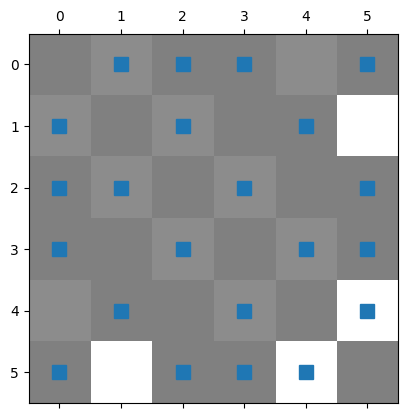

[[  0.   1.   1.  10.   0.  10.]
 [  1.   0.   1.   0.  10.   0.]
 [  1.   1.   0. -10.   0.  10.]
 [ 10.   0. -10.   0.  -1.  -1.]
 [  0.  10.   0.  -1.   0.  -1.]
 [ 10.   0.  10.  -1.  -1.   0.]]


In [ ]:
#Teste visualização

import matplotlib.pylab as plt
import scipy.sparse as sparse

import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

#BdG_Hamiltonian(n,  delta_in, T,  t =1, V =1, periodic = True)

A=BdG_Hamiltonian_Spin(3, 10, 0.5, 1, 0.1,periodic = True)
plt.spy(A)

sparse_matrix = BdG_Hamiltonian(5, 10, 0.1, 1, 0.1, periodic = True)

# convert to dense numpy array and plot

dense_array = sparse_matrix.toarray()
plt.imshow(dense_array, cmap='gray')
plt.show()

print(A.toarray())

In [ ]:
def gap_function(n, T_array, t=1, V=1, epsilon=1e-2, delta_guess = 1.0):
  '''
  Função que calcula o gap de um sistema de modo
  autoconsistente para uma lista de temperaturas

  Argumentos:
  n: número de sítios(int)
  T_array: lista de temperaturas do sistema(list of floats)
  t: Termo de hopping(float)
  V: Parâmetro superconductor(float)
  epsilon: Valor de convergência para a autoconsistência(float)

  Return: lista de valores de delta em função da temperatura
  '''
  delta_array = []
  delta_in = 1.0




  for i, T in enumerate(T_array):
    print(f"Computing delta for T = {T}...", delta_in)
    if i == 0:
      # Initial guess for the first temperature
      delta_in = delta_guess
    else:
      # Use the last computed delta as the initial guess for the next temperature
      delta_in = delta_array[i-1]

    # Compute the gap using self-consistent calculation
    c= 0
    while True:


      sparse = BdG_Hamiltonian_Spin(n, t=t, delta_in=delta_in, V=V, T=T)
      eigenvalues, eigenvectors = eigsh(sparse, tol = 1e-1, k = 2*n-1)

      delta_next = 0.0


      for j in range(len(eigenvalues)):
        u, v = np.split(eigenvectors[:, j], 2)
        delta_next += V * v[1] * u[1] * np.tanh(eigenvalues[j] / (2*k*T))



      epsilon =2*max(eigenvalues)*np.exp(-1/(1045*V))/200

      if abs(abs(delta_next) - abs(delta_in)) < epsilon:

        delta_in = delta_next
        break

      delta_in = delta_next

    delta_array.append(delta_in)

  print(epsilon)
  print(eigenvalues)
  return delta_array


In [ ]:
from scipy.constants import k
import matplotlib.pyplot as plt

#k = 0.0861733
k=1.0
T_array = np.linspace(1e-2, 200, 100)
t=1.0
V = 100*t
n = 100
delta_array = gap_function(n=n, T_array=T_array, V = V, t = t, epsilon=1e-2)

print(delta_array)


plt.scatter(T_array, abs(delta_array/delta_array[0]),
            label =r"${} sítios; V = {}; t = {}; \Delta(0) = {:.2f}$" .format(n, V, t, delta_array[0]))
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\frac{\Delta}{\Delta(0)}$')
plt.legend()
plt.show()


Computing delta for T = 0.01... 1.0
Computing delta for T = 2.03010101010101... 97.97287584435678
Computing delta for T = 4.05020202020202... 97.97287742660757
Computing delta for T = 6.07030303030303... 97.97287741860414
Computing delta for T = 8.09040404040404... 97.97285826680688
Computing delta for T = 10.11050505050505... 97.97179941724309
Computing delta for T = 12.13060606060606... 97.96074581307819


KeyboardInterrupt: ignored

In [ ]:
#data generating
from scipy.constants import k
import matplotlib.pyplot as plt


k = 0.0861733
T_array = np.linspace(0.01, 310, 50)
V_array = np.linspace(25, 100, 50)
N_array = [10,25,50,100]
delta_array = gap_function(n=int(n), T_array=T_array, V = V)
data = np.stack((delta_array, T_array, n*np.ones(len(T_array)), V*np.ones(len(T_array))), axis = 1)
for n in N_array:
  for V in V_array:
    delta_array = gap_function(n=int(n), T_array=T_array, V = V)
    new_data = np.stack((delta_array, T_array, n*np.ones(len(T_array)), V*np.ones( len(T_array))), axis = 1)
    data = np.vstack((new_data, data))



A saída de streaming foi truncada nas últimas 5000 linhas.
Computing delta for T = 183.47346938775507... 86.51168081424241
Computing delta for T = 189.79979591836732... 90.19925921002185
Computing delta for T = 196.12612244897957... 86.2272663405267
Computing delta for T = 202.45244897959182... 86.05358252648233
Computing delta for T = 208.77877551020407... 85.86053689929528
Computing delta for T = 215.10510204081632... 89.54630979359894
Computing delta for T = 221.43142857142857... 89.33086974763742
Computing delta for T = 227.7577551020408... 85.15275169052337
Computing delta for T = 234.08408163265304... 88.82719638915822
Computing delta for T = 240.4104081632653... 88.5400354752874
Computing delta for T = 246.73673469387754... 88.3130784039134
Computing delta for T = 253.0630612244898... 87.99924099176594
Computing delta for T = 259.389387755102... 87.514075986358
Computing delta for T = 265.7157142857143... 87.258066304811
Computing delta for T = 272.0420408163265... 82.6134723719

In [ ]:
np.savetxt('data_spin_periodic', data)

                1      2      3
0        0.010000  100.0  100.0
1        6.336327  100.0  100.0
2       12.662653  100.0  100.0
3       18.988980  100.0  100.0
4       25.315306  100.0  100.0
...           ...    ...    ...
10045  284.694694  100.0  100.0
10046  291.021020  100.0  100.0
10047  297.347347  100.0  100.0
10048  303.673673  100.0  100.0
10049  310.000000  100.0  100.0

[10050 rows x 3 columns]
                1      3
0        0.010000  100.0
1        6.336327  100.0
2       12.662653  100.0
3       18.988980  100.0
4       25.315306  100.0
...           ...    ...
10045  284.694694  100.0
10046  291.021020  100.0
10047  297.347347  100.0
10048  303.673673  100.0
10049  310.000000  100.0

[10050 rows x 2 columns]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Random grid:  {'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 20, 50, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [4], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 200, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 4, 'bootstrap': True}  



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Time:  0.06246728500082099
time per test:  1.5539125622094773e-05
5.521702215019802
0.9629925987267067 0.9662040957731336


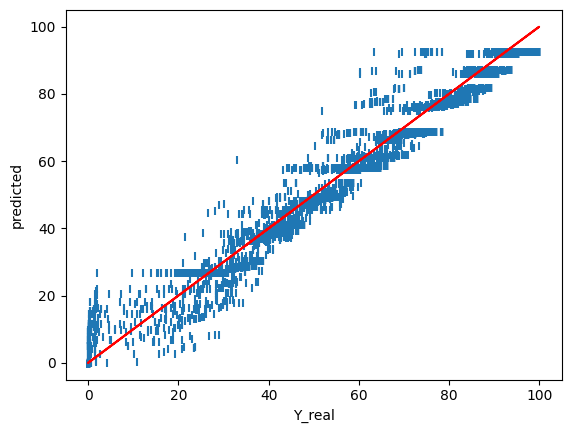

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

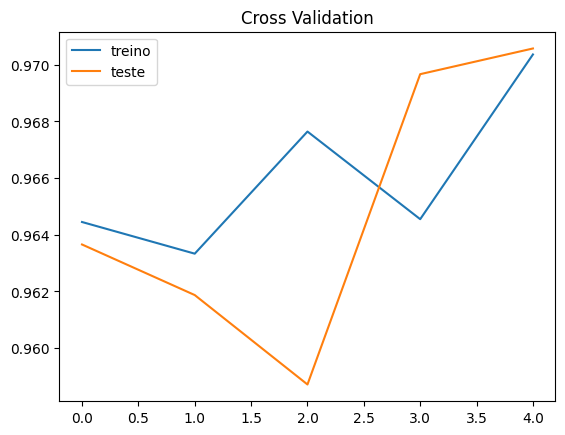

In [42]:
data = np.loadtxt('data_spin_periodic')
data
#first test
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

data = pd.DataFrame(data)
Y = data.iloc[:,0]
X = data.iloc[:,1:]
print(X)
X = X.drop(X.columns[1], axis=1)
print(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, random_state = 42)#40% for train

#Scaling Data
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

#Hyperparameters tuning
n_estimators = [2,3,4,5,6,7,8,9, 20,50,100, 200] # number of trees
max_features = ['auto', 'sqrt'] # max number of features for each split
max_depth = [int(x) for x in np.linspace(4, 30, num = 1)] #length for each tree
min_samples_split = [2, 4, 6,8, 10] # min number of features for each split
min_samples_leaf = [1, 2,3, 4] # min number of samples leaf
bootstrap = [True, False]

#grid to search the best parameters
random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap,}


rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

rf_random.fit(X_train, Y_train)

print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

#using the best model
randmf = RandomForestRegressor(**rf_random.best_params_)
randmf.fit( X_train, Y_train)

import timeit
from sklearn.metrics import mean_absolute_percentage_error

start = timeit.default_timer()

pred_i=randmf.predict( X_test)
stop = timeit.default_timer()

print('Time: ', stop - start)
print('time per test: ', (stop - start)/X_test.shape[0])

mean_absolute_percentage_error(Y_test, pred_i)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, pred_i)
rmse = np.sqrt(mse)
print(rmse)
from sklearn.metrics import r2_score
r2_score(Y_test, pred_i)
y_train_predict = randmf.predict(X_train)
print(r2_score(Y_test, pred_i), r2_score(Y_train, y_train_predict))

plt.scatter(Y_test, pred_i, marker=3)
plt.plot(Y_test, Y_test, color ='r')
plt.ylabel('predicted')
plt.xlabel('Y_real')
plt.show()

from sklearn.model_selection import cross_val_score,KFold

kf=KFold(n_splits=5)
score_train=cross_val_score(randmf,X_train,Y_train,cv=kf)
#cross validation
from sklearn.model_selection import cross_val_score,KFold
kf=KFold(n_splits=5)
score_test=cross_val_score(randmf,X_test,Y_test,cv=kf)

plt.plot(score_train, label = 'treino')
plt.plot(score_test, label = 'teste')
plt.title('Cross Validation')
plt.legend()
plt.show()

In [ ]:
data[:, 1]

array([1.00000000e-02, 6.33632653e+00, 1.26626531e+01, ...,
       2.97347347e+02, 3.03673673e+02, 3.10000000e+02])

In [47]:

data = np.loadtxt('data_spin_periodic')
def erro_gap(real, pred, data):
  data_0 = []

  for i in range(len(data)):
    if (data[i, 1] == 1e-2):
      data_0.append(data[i, 0])

  dif = np.abs(real, pred)

  print(np.mean(data_0)/1000, dif)

erro_gap(Y_test, pred_i, data)


0.060347706066593655 8776    44.624363
2199     0.002011
9596     0.016926
8490    63.937958
3314    72.412114
          ...    
722     78.333898
9659    34.095780
4775    18.732984
220     93.834727
9235    35.017095
Name: 0, Length: 4020, dtype: float64


In [43]:


import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Model
from keras import Sequential
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.losses import MeanSquaredLogarithmicError

hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model
# build the model
model = build_model_using_sequential()

# loss function
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle,
    optimizer=Adam(learning_rate=learning_rate),
    metrics=[msle]
)
# train the model
history = model.fit(
    scaled_X_train,
    Y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2
)

Epoch 1/100
19/19 [==============================] - 1s 27ms/step - loss: 2.9010 - mean_squared_logarithmic_error: 2.8820 - val_loss: 0.6248 - val_mean_squared_logarithmic_error: 0.6226
Epoch 2/100
19/19 [==============================] - 0s 18ms/step - loss: 0.3318 - mean_squared_logarithmic_error: 0.3301 - val_loss: 0.1461 - val_mean_squared_logarithmic_error: 0.1438
Epoch 3/100
19/19 [==============================] - 0s 16ms/step - loss: 0.1329 - mean_squared_logarithmic_error: 0.1326 - val_loss: 0.0708 - val_mean_squared_logarithmic_error: 0.0704
Epoch 4/100
19/19 [==============================] - 0s 16ms/step - loss: 0.0776 - mean_squared_logarithmic_error: 0.0774 - val_loss: 0.0465 - val_mean_squared_logarithmic_error: 0.0460
Epoch 5/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0611 - mean_squared_logarithmic_error: 0.0610 - val_loss: 0.0394 - val_mean_squared_logarithmic_error: 0.0390
Epoch 6/100
19/19 [==============================] - 1s 29ms/step - lo

In [44]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Model
from keras import Sequential
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.losses import MeanAbsoluteError

hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 0.001  # Adjust the learning rate

# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
    model = Sequential([
        Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
        Dropout(0.2),
        Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
        Dropout(0.2),
        Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
        Dense(1, kernel_initializer='normal', activation='linear')
    ])
    return model

# Build the model
model = build_model_using_sequential()

# Loss function
mae = MeanAbsoluteError()
model.compile(
    loss=mae,
    optimizer=Adam(learning_rate=learning_rate),
    metrics=[mae]
)

# Train the model
history = model.fit(
    scaled_X_train,
    Y_train,
    epochs=100,
    batch_size=32,  # Reduce batch size for more frequent weight updates
    validation_split=0.2
)


Epoch 1/100
151/151 [==============================] - 2s 10ms/step - loss: 18.3285 - mean_absolute_error: 18.3075 - val_loss: 4.4055 - val_mean_absolute_error: 4.4042
Epoch 2/100
151/151 [==============================] - 1s 7ms/step - loss: 4.3460 - mean_absolute_error: 4.3437 - val_loss: 2.8372 - val_mean_absolute_error: 2.8298
Epoch 3/100
151/151 [==============================] - 1s 7ms/step - loss: 3.8551 - mean_absolute_error: 3.8525 - val_loss: 2.3065 - val_mean_absolute_error: 2.3014
Epoch 4/100
151/151 [==============================] - 1s 7ms/step - loss: 3.5316 - mean_absolute_error: 3.5309 - val_loss: 2.5229 - val_mean_absolute_error: 2.5175
Epoch 5/100
151/151 [==============================] - 1s 7ms/step - loss: 3.3709 - mean_absolute_error: 3.3727 - val_loss: 2.2118 - val_mean_absolute_error: 2.2067
Epoch 6/100
151/151 [==============================] - 1s 7ms/step - loss: 3.3840 - mean_absolute_error: 3.3841 - val_loss: 2.1156 - val_mean_absolute_error: 2.1129
Epoch 7

In [48]:
'''def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')'''

y_pred2 = model.predict(X_test)
erro_gap(Y_test, y_pred2[:,0], data)

126/126 [==============================] - 0s 3ms/step
0.060347706066593655 8776    44.624363
2199     0.002011
9596     0.016926
8490    63.937958
3314    72.412117
          ...    
722     78.333900
9659    34.095779
4775    18.732985
220     93.834724
9235    35.017094
Name: 0, Length: 4020, dtype: float32


In [ ]:
-np.log(92.04/(2*130.87))*1000

1045.1283794601693

(array([1183.,  224.,  739.,  998., 1102., 1195., 1257., 1206., 1168.,
         978.]),
 array([-7.32374232e-03,  9.99262205e+00,  1.99925678e+01,  2.99925136e+01,
         3.99924594e+01,  4.99924052e+01,  5.99923510e+01,  6.99922968e+01,
         7.99922426e+01,  8.99921884e+01,  9.99921341e+01]),
 <BarContainer object of 10 artists>)

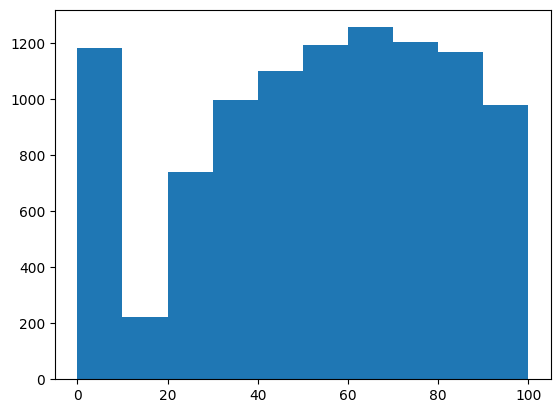

In [ ]:
plt.hist(Y)

N(0) = 1045.13

$$\Delta = 2ħ ω_C exp(\frac{-1}{N(0)V})$$

Computing delta for T = 0.01... 1.0
Computing delta for T = 100.0... 99.98999721562431
0.02000574467245359
[-2.00059361 -2.00011249 -2.00010885 ...  2.00010885  2.00011249
  2.00059361]
[99.98999721562431, 0.010991067048901093]


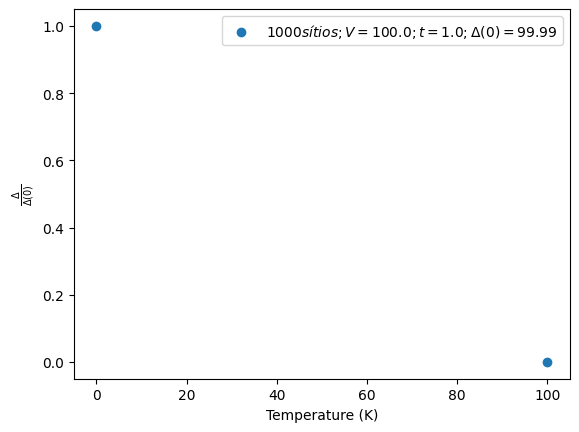

In [ ]:
from scipy.constants import k
import matplotlib.pyplot as plt

#k = 0.0861733
k=1.0
T_array = np.linspace(1e-2, 100, 2)
t=1.0
V = 100*t
n = 1000
delta_array = gap_function(n=n, T_array=T_array, V = V, t = t, epsilon=1e-2)

print(delta_array)


plt.scatter(T_array, abs(delta_array/delta_array[0]),
            label =r"${} sítios; V = {}; t = {}; \Delta(0) = {:.2f}$" .format(n, V, t, delta_array[0]))
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\frac{\Delta}{\Delta(0)}$')
plt.legend()
plt.show()

In [ ]:
T_array[1]

100.0

In [ ]:
A = np.array([[0, 50], [150, 50],  [300, 50]])

randmf.predict(A)

array([44.41085656, 44.41085656, 15.36312214])

In [ ]:
T_array

array([1.e-02, 1.e+02])

In [ ]:
from scipy.constants import k
import matplotlib.pyplot as plt

#k = 0.0861733
k=1.0
T_array = np.linspace(1e-2, 300, 3)
t = 1.0
V = 50*t
n = 1000
delta_array = gap_function(n=n, T_array=T_array, V = V, t = t, epsilon=1e-2)

print(delta_array)


plt.scatter(T_array, abs(delta_array/delta_array[0]),
            label =r"${} sítios; V = {}; t = {}; \Delta(0) = {:.2f}$" .format(n, V, t, delta_array[0]))
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\frac{\Delta}{\Delta(0)}$')
plt.legend()
plt.show()

Computing delta for T = 0.01... 1.0
Computing delta for T = 150.005... 49.979926248497286


KeyboardInterrupt: ignored